In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MarketingConsultantFinal').getOrCreate()

In [2]:
df = spark.read.csv('bank.csv',inferSchema=True,
                     header=True,)

In [3]:
df = df.withColumnRenamed("y","label")
df.toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,EmpVarRate,ConsPriceIDX,ConsConfIDX,euribor3m,NrEmployed,label,notcontacted
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0,1


In [4]:
train, test = df.randomSplit([0.7, 0.3], seed=10)

In [5]:
catCols = [x for (x, dataType) in train.dtypes if dataType == "string" ]

numCols = [x for (x, dataType) in train.dtypes if ((dataType != "string") & (x != "label"))]

In [6]:
from feature_engine import transformation as vt
tf = vt.YeoJohnsonTransformer(variables = ['age'])
tf.fit(train.toPandas())
train= tf.transform(train.toPandas())
test= tf.transform(test.toPandas())

In [7]:
#changing it back to the spark dataframe 
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
train = spark.createDataFrame(train)
test = spark.createDataFrame(test)

In [8]:
catCols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [9]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
string_indexer = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in catCols]
one_hot_encoder = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in catCols]

In [10]:
from pyspark.ml.feature import VectorAssembler
assembler = [x for x in numCols]
assembler += [f"{x}_one_hot" for x in catCols]

In [11]:
vector_assembler = VectorAssembler(
    inputCols= assembler, outputCol= "vfeatures"
)

In [12]:
from pyspark.ml.feature import MinMaxScaler
std_scaler = MinMaxScaler(inputCol="vfeatures", outputCol="features")

In [13]:
stages = []

stages += string_indexer
stages += one_hot_encoder
stages += [vector_assembler]
stages += [std_scaler]

In [14]:
from pyspark.ml import Pipeline
pipeline = Pipeline().setStages(stages)
model = pipeline.fit(train)
train = model.transform(train)
test = model.transform(test)

In [15]:
train.select('label',"features").show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(53,[0,4,5,6,7,8,...|
|    1|(53,[0,3,4,5,6,7,...|
+-----+--------------------+
only showing top 2 rows



In [16]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
Model = GBTClassifier(featuresCol="features", labelCol="label",  maxIter=10)

In [17]:
# Fit the model
model = Model.fit(train)
# Test the model performance on the test dataset
pred = model.transform(test)

In [18]:
import sklearn
y_true = pred.select(['label']).collect()
y_pred = pred.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     11060
           1       0.65      0.26      0.37      1360

    accuracy                           0.90     12420
   macro avg       0.78      0.62      0.66     12420
weighted avg       0.89      0.90      0.88     12420



In [19]:
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix

array([[10869,   191],
       [ 1004,   356]], dtype=int64)

In [20]:
eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
ANN_AUC  = eval.evaluate(pred)
print("AUC = " , ANN_AUC)

AUC =  0.797443656259972


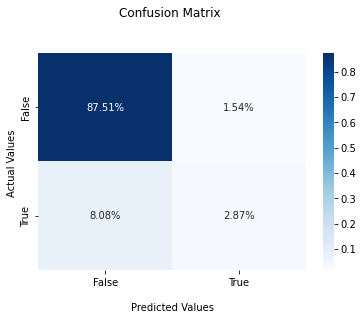

In [21]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()